# Investigate Bering-Chukchi surface flux-wind-transport anomaly feedback

**Turn this notebook into one that finds the trend of the observational fields using linear regression of the monthly anomalies and only plots the statistically significant linear trends in the observations of the surface fields**




Danielson et al. 2020 propose a feedback loop for Arctic amplification where the elevated ocean temperatures in the summer and fall lead to an enhanced ocean to atmosphere heat flux that strengthens the northward winds through Bering Strait. The change in wind strength increases Bering Strait volume transports through stronger, northward geostrophic currents in Bering Strait.

This notebook compares the time series of the monthly anomalies for:
1. summer/fall Chukchi Sea SST
2. summer/fall surface heat fluxes over the Chukchi Sea
3. fall winds over the Bering strait
4. fall Bering Strait ocean heat and volume fluxes

First we just want to see if there is a corresponding increase in the meridional wind anonmaly over time for the Bering Strait region in the observations (using ERA 5 monthly winds).

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

In [3]:
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

## Set observational paths

In [4]:
# SST
sst_dir = '/work/Marion.Alberty/data/OISST_pp/'
# Heat fluxes
hF_dir = '/uda/ERA5/Monthly_Averaged_Data_On_Single_Levels/reanalysis/global/annual_file-range/Mean_rates/'
# Winds
v10_dir = '/work/Marion.Alberty/data/ERA5_pp/v_10m/'
# Transports
T_path = '../data/BeringStraitMooring/'
# ERA5 land mask
e5lm_dir = '/uda/ERA5/Monthly_Averaged_Data_On_Single_Levels/reanalysis/global/annual_file-range/Other/land-sea_mask/'

## Get file lists

In [5]:
# SST
flist_sst = glob(f'{sst_dir}NCEI_OISST_monthly_SST_*.nc')
# Heat fluxes
flist_sw = glob(f'{hF_dir}mean_surface_net_short-wave_rad_flux/*.nc')
flist_lw = glob(f'{hF_dir}mean_surface_net_long-wave_rad_flux/*.nc')
flist_lt = glob(f'{hF_dir}mean_surface_latent_heat_flux/*.nc')
flist_sn = glob(f'{hF_dir}mean_surface_sensible_heat_flux/*.nc')
# Winds
flist_v10 = glob(f'{v10_dir}ERA5_monthly_v_10m_*.nc')
# Transports
flist_T = f'{T_path}BeringStrait_Monthlymeans_Jan2021.nc'
# ERA 5 land-sea mask
flist_e5lm = f'{e5lm_dir}ERA5_monthly_averaged_land_sea_mask_2021.nc'

## Read in observational data

In [6]:
def fix_latlon(ds):
    # Rename to lat, lon
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
    # reindex for increasing lat
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    return ds

In [7]:
# SST
DS_sst = xr.open_mfdataset(flist_sst,engine='netcdf4')

In [ ]:
# Net short wave
DS_sw = fix_latlon(xr.open_mfdataset(flist_sw,engine='netcdf4'))

In [ ]:
# Net long wave
DS_lw = fix_latlon(xr.open_mfdataset(flist_lw,engine='netcdf4'))

In [ ]:
# Latent
DS_lt = fix_latlon(xr.open_mfdataset(flist_lt,engine='netcdf4'))

In [ ]:
# Sensible
DS_sn = fix_latlon(xr.open_mfdataset(flist_sn,engine='netcdf4'))

In [8]:
# Winds
DS_v10 = fix_latlon(xr.open_mfdataset(flist_v10,engine='netcdf4'))

In [9]:
# Transports
DS_T = xr.open_dataset(flist_T,engine='netcdf4')

In [10]:
# ERA5 land mask
DS_e5lm = fix_latlon(xr.open_dataset(flist_e5lm,engine='netcdf4')).isel(time=0).drop_vars('time')

## Make grid objects and add metrics

In [11]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [12]:
def add_grid_area_c(ds):
    # add left coords
    ds = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
    # make grid object
    grid = Grid(ds, periodic=['X'])
    # calc dlat, dlon
    dlonc = grid.diff(ds.lon_left, 'X', boundary_discontinuity=360)
    dlatc = grid.diff(ds.lat_left, 'Y', boundary='fill', fill_value=np.nan)
    # convert to distances
    ds.coords['dxc'], ds.coords['dyc'] = dll_dist(dlonc, dlatc, ds.lon, ds.lat)
    # compute grid area
    ds.coords['area'] = ds.dxc * ds.dyc
    return ds, grid

In [13]:
def add_grid_area_g(ds):
    # add left coords
    ds = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'},
                          position={'X':('left','center'),'Y':('left','center')})
    # make grid object
    grid = Grid(ds, periodic=['X'])
    # calc dlat, dlon
    dlong = grid.diff(ds.lon_center, 'X', boundary_discontinuity=360)
    dlatg = grid.diff(ds.lat_center, 'Y', boundary='fill', fill_value=np.nan)
    # convert to distances
    ds.coords['dxg'], ds.coords['dyg'] = dll_dist(dlong, dlatg, ds.lon, ds.lat)
    # compute grid area
    ds.coords['area'] = ds.dxg * ds.dyg
    return ds, grid

In [14]:
# SST
DS_sst, grid_sst = add_grid_area_c(DS_sst)

In [15]:
# Heat fluxes

In [16]:
# Winds
DS_v10, grid_v10 = add_grid_area_g(DS_v10)

## Get lat,lon for analysis

In [17]:
# SST
lat_sst = np.array([66, 72])
lon_sst = np.array([180, 204])

In [18]:
# heat fluxes

In [19]:
# Winds
lat_v10 = np.array([54, 74])
lon_v10 = np.array([185, 200])

## Maps of analysis regions

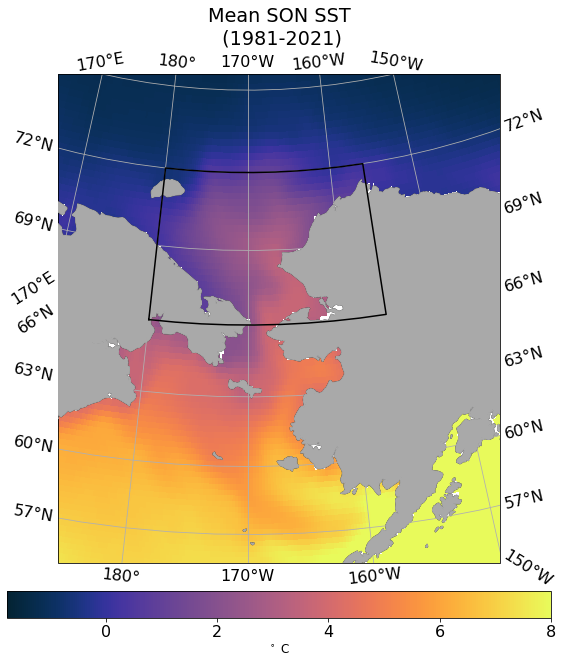

In [20]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),dpi=100,
                      subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_sst['lon']
Y = DS_sst['lat']
Z = DS_sst['sst'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.thermal',vmax=8)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON SST\n ({DS_sst.time.dt.year.values[0]}-{DS_sst.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ$ C',fontsize=12)
bx_lons = np.concatenate(([lon_sst[0]], np.linspace(lon_sst[0],lon_sst[1],10),  np.linspace(lon_sst[1],lon_sst[0],10)))
bx_lats = np.concatenate(([lat_sst[0]], lat_sst[1]*np.ones((10,), dtype=int),  lat_sst[0]*np.ones((10,), dtype=int)))
plt.plot(bx_lons,bx_lats,c='k',transform=crs,zorder=10)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

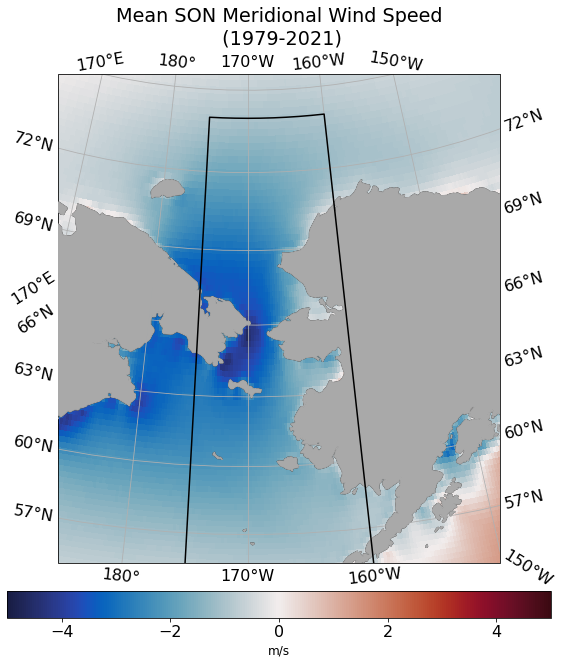

In [21]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_v10['lon']
Y = DS_v10['lat']
Z = DS_v10['v10'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.balance',vmin=-5, vmax=5)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON Meridional Wind Speed\n ({DS_v10.time.dt.year.values[0]}-{DS_v10.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('m/s',fontsize=12)
bx_lons = np.concatenate(([lon_v10[0]], np.linspace(lon_v10[0],lon_v10[1],10),  np.linspace(lon_v10[1],lon_v10[0],10)))
bx_lats = np.concatenate(([lat_v10[0]], lat_v10[1]*np.ones((10,), dtype=int),  lat_v10[0]*np.ones((10,), dtype=int)))
plt.plot(bx_lons,bx_lats,c='k',transform=crs,zorder=10)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

## Extract regions for analysis

In [22]:
# SST
sst = DS_sst.sel(lon=slice(lon_sst[0],lon_sst[1]),lat=slice(lat_sst[0],lat_sst[1]))
# Mask land
sst['area'][:,:] = sst.area.where(sst['sst'].isel(time=0).notnull()).values

In [23]:
# Heat fluxes

In [24]:
# Winds
# Mask land
DS_v10['area'][:,:] = DS_v10['area'] * (1 - DS_e5lm['lsm'])
# Extract
v10 = DS_v10.sel(lon=slice(lon_v10[0],lon_v10[1]),lat=slice(lat_v10[0],lat_v10[1]))

In [25]:
# Transport
T = DS_T

## calc standard error of slope coefficient from linear regression

In [10]:
# Winds
# Extract
v10 = DS_v10.sel(lon=slice(lon_v10[0],lon_v10[1]),lat=slice(lat_v10[0],lat_v10[1]))

In [12]:
SSE = v10.isel(time=v10.groupby('time.month').groups[12]).polyfit('time',1,full=True)['v10_polyfit_residuals']

In [15]:
N = len(v10.isel(time=v10.groupby('time.month').groups[12]).time)

In [16]:
s_err = (SSE/ N-2)**(1/2)

In [37]:
dt = (v10.isel(time=v10.groupby('time.month').groups[12]).time - 
      v10.isel(time=v10.groupby('time.month').groups[12]).time.mean()).astype(int)

In [39]:
s_b1 = s_err/((dt**2).sum()**(1/2))

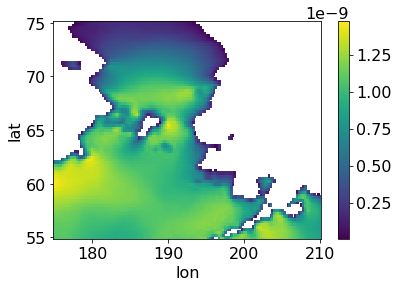

In [41]:
s_b1.plot()

In [55]:
t_con = 1e9 * 86400 * 365.25

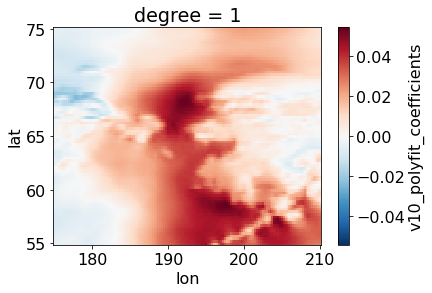

In [57]:
(t_con * v10.isel(time=v10.groupby('time.month').groups[10]
                 ).polyfit('time',1)['v10_polyfit_coefficients'].sel(degree=1)).plot()

## Calc area-mean, climatology, and anomaly

In [26]:
# SST
# mean
sst['bx_mean'] = ((sst['sst'] * sst.area).sum(['lat','lon']) / sst.area.sum(['lat','lon']))
# climatology
sst['clim'] = sst['bx_mean'].groupby("time.month").mean("time")
# anomaly
sst['anom'] = sst['bx_mean'].groupby("time.month") - sst['clim']

In [27]:
# Heat fluxes


In [28]:
# Winds
# area mean
v10['bx_mean'] = ((v10['v10'] * v10.area).sum(['lat','lon']) / v10.area.sum(['lat','lon']))
# climatology
v10['clim'] = v10['bx_mean'].groupby("time.month").mean("time")
# anomaly
v10['anom'] = v10['bx_mean'].groupby("time.month") - v10['clim']

In [29]:
# Transport
# climatology
T['clim'] = T['T_vol'].groupby("time.month").mean("time")
# anomaly 
T['anom'] = T['T_vol'].groupby("time.month") - T['clim']

## Plot Fall anomalies for each field

In [30]:
t0 = v10.time.values[0]
tn = v10.time.values[-1]

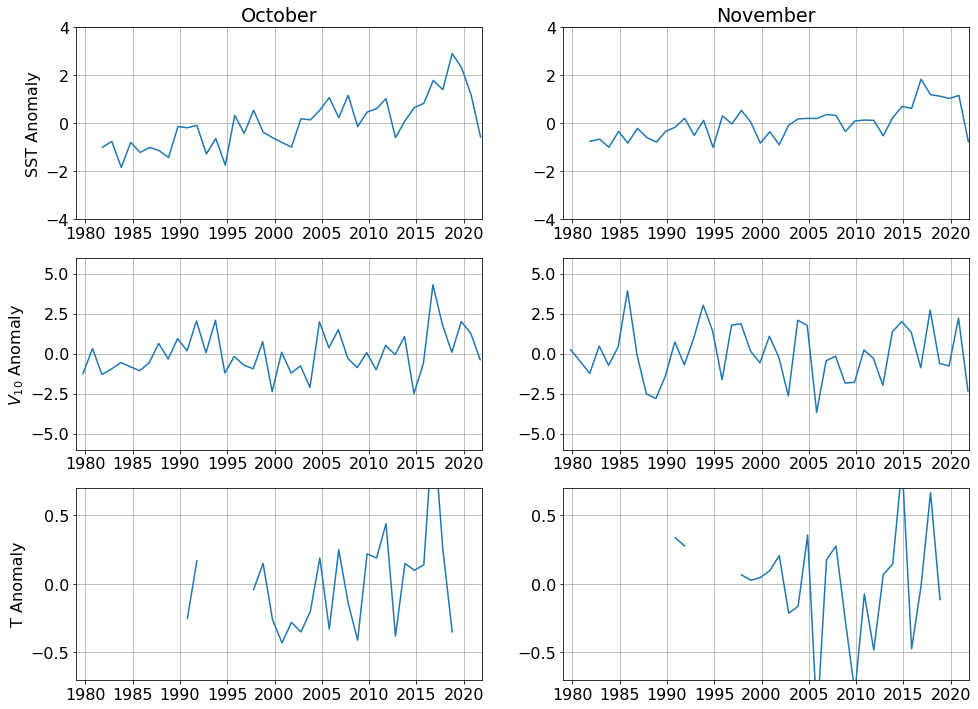

In [31]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(16,12))

# October
im = 10
# SST
x = sst['time'].sel(time=sst.time.dt.month.isin(im))
y = sst['anom'].sel(time=sst.time.dt.month.isin(im))
ax0.plot(x,y)
ax0.set_title('October')
ax0.set_ylabel('SST Anomaly')
ax0.set_ylim(-4,4)
ax0.set_xlim(t0,tn)
ax0.grid()

# Winds
x = v10['time'].sel(time=v10.time.dt.month.isin(im))
y = v10['anom'].sel(time=v10.time.dt.month.isin(im))
ax2.plot(x,y)
ax2.set_ylabel('$V_{10}$ Anomaly')
ax2.set_ylim(-6,6)
ax2.set_xlim(t0,tn)
ax2.grid()

# Transport
x = T['time'].sel(time=T.time.dt.month.isin(im)).astype("datetime64[ns]")
y = T['anom'].sel(time=T.time.dt.month.isin(im))
ax4.plot(x,y)
ax4.set_ylabel('T Anomaly')
ax4.set_ylim(-0.7,0.7)
ax4.set_xlim(t0,tn)
ax4.grid()

# November
im = 11
# SST
x = sst['time'].sel(time=sst.time.dt.month.isin(im))
y = sst['anom'].sel(time=sst.time.dt.month.isin(im))
ax1.plot(x,y)
ax1.set_title('November')
ax1.set_ylim(-4,4)
ax1.set_xlim(t0,tn)
ax1.grid()

# Winds
x = v10['time'].sel(time=v10.time.dt.month.isin(im))
y = v10['anom'].sel(time=v10.time.dt.month.isin(im))
ax3.plot(x,y)
ax3.set_ylim(-6,6)
ax3.set_xlim(t0,tn)
ax3.grid()

# Transport
x = T['time'].sel(time=T.time.dt.month.isin(im)).astype("datetime64[ns]")
y = T['anom'].sel(time=T.time.dt.month.isin(im))
ax5.plot(x,y)
ax5.set_ylim(-0.7,0.7)
ax5.set_xlim(t0,tn)
ax5.grid()

plt.show()